In [ ]:
## Combine datasets -- NOT IN USE
import glob
import torch
from pathlib import Path

def merge_pt_files(pt_paths):
    merged = {}
    for path in pt_paths:
        data = torch.load(path, map_location='cpu')
        if not merged:
            merged = {k: [v] for k, v in data.items()}
            continue
        if data.keys() != merged.keys():
            print(data.keys(),merged.keys())
            raise ValueError(f"Key mismatch in {path}")
        for k, v in data.items():
            merged[k].append(v)
    for k, tensors in merged.items():
        try:
            merged[k] = torch.cat(tensors, dim=0)
        except RuntimeError:
            merged[k] = tensors 
    return merged

pt_files = glob.glob("torchfem_dataset/panel_plasticity/*.pt")
combined = merge_pt_files(pt_files)
torch.save(combined, "torchfem_dataset/panel_plasticity/combined.pt")



In [ ]:
## Modify Dataset with Material Labels -- NOT IN USE AS OF NOV 8
import torch
import glob
from pathlib import Path
import pandas as pd
mat_df = pd.read_csv("../torchfem_dataset/tube/materials.csv")

files = glob.glob('../torchfem_dataset/panel_plasticity/simulation_dump*.pt')

material_map = {'concrete':0,'steel':1,'aluminum':2,'CFRP':3}

def stiffness_to_edges(K, num_nodes, dof_per_node=3):
    K = K.coalesce()
    dof_rows, dof_cols = K.indices()
    node_rows = torch.div(dof_rows, dof_per_node, rounding_mode='floor')
    node_cols = torch.div(dof_cols, dof_per_node, rounding_mode='floor')
    block_ids = node_rows * num_nodes + node_cols

    uniq_blocks, inverse = torch.unique(block_ids, return_inverse=True)
    local_row = dof_rows % dof_per_node
    local_col = dof_cols % dof_per_node
    flat_offsets = inverse * (dof_per_node * dof_per_node) + local_row * dof_per_node + local_col

    edge_attr_flat = torch.zeros(
        uniq_blocks.numel() * dof_per_node * dof_per_node,
        dtype=K.values().dtype,
        device=K.values().device,
    )
    edge_attr_flat.scatter_add_(0, flat_offsets, K.values())
    edge_attr = edge_attr_flat.view(uniq_blocks.numel(), dof_per_node, dof_per_node)

    senders = torch.div(uniq_blocks, num_nodes, rounding_mode='floor')
    receivers = uniq_blocks % num_nodes
    return senders.long(), receivers.long(), edge_attr.reshape(uniq_blocks.numel(), -1).float()

def build_graph_sample(material,sim, t_stride=1):
    nodes = sim["nodes"].float()
    u_hist = sim["u_history"][::t_stride].float()
    f_hist = sim["forces"][::t_stride].float()
    dirichlet = sim.get("dirichlet_disp", torch.zeros_like(nodes)).float()
    constraints = sim.get("boundary", sim.get("constraints", torch.zeros_like(nodes, dtype=torch.bool))).float()

    static = torch.cat([nodes, dirichlet, constraints], dim=-1)
    static = static.unsqueeze(0).expand(u_hist.size(0), -1, -1)
    dynamic = torch.cat([u_hist, f_hist], dim=-1)
    node_features = torch.cat([static, dynamic], dim=-1)

    senders, receivers, edge_features = stiffness_to_edges(
        sim["stiffness"],
        num_nodes=nodes.size(0),
        dof_per_node=nodes.size(1),
    )

    return {
        "node_features": node_features,
        "edge_features": edge_features,
        "senders": senders,
        "receivers": receivers,
        "target": u_hist,
    }

def preprocess_panel_dataset(src_dir="../torchfem_dataset/panel_plasticity",
                             dst_path="../torchfem_dataset/panel_processed.pt",
                             t_stride=1):
    src_dir = Path(src_dir)
    samples = []
    for pt_file in sorted(src_dir.glob("simulation_dump*.pt")):
        idx = int(str(pt_file).split('simulation_dump_')[1].split('.pt')[0])
        material = mat_df[mat_df['0']==idx]
        mat = material['1'].item()
        sim = torch.load(pt_file, map_location="cpu")
        samples.append(build_graph_sample(mat,sim, t_stride=t_stride))
    Path(dst_path).parent.mkdir(parents=True, exist_ok=True)
    #torch.save(samples, dst_path)
    print(f"Wrote {len(samples)} samples to {dst_path}")

# Run once to create the processed file
preprocess_panel_dataset()

aluminum
steel
aluminum
steel
aluminum
aluminum
steel
CFRP
CFRP
aluminum
aluminum
steel
steel
steel
aluminum
CFRP
CFRP
CFRP
steel
CFRP
CFRP
steel
CFRP
CFRP
CFRP
CFRP
aluminum
CFRP
aluminum
CFRP
steel
CFRP
aluminum
aluminum
CFRP
steel
aluminum
CFRP
CFRP
steel
steel
steel
CFRP
aluminum
CFRP
steel
aluminum
CFRP
CFRP
aluminum
steel
steel
aluminum
CFRP
steel
CFRP
aluminum
CFRP
steel
steel
aluminum
CFRP
aluminum
CFRP
aluminum
steel
steel
aluminum
aluminum
CFRP
CFRP
steel
CFRP
steel
steel
aluminum
CFRP
steel
CFRP
CFRP
steel
CFRP
aluminum
aluminum
aluminum
aluminum
steel
aluminum
CFRP
aluminum
CFRP
steel
steel
CFRP
steel
aluminum
CFRP
CFRP
steel
CFRP
aluminum
steel
CFRP
CFRP
aluminum
aluminum
steel
steel
aluminum
CFRP
CFRP
CFRP
steel
CFRP
steel
CFRP
aluminum
CFRP
CFRP
aluminum
CFRP
steel
CFRP
CFRP
Wrote 124 samples to ../torchfem_dataset/panel_processed.pt


In [ ]:
## PyG HeteroData -- NOT IN USE
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import numpy as np
import torch
from torch_geometric.data import HeteroData
import pandas as pd

def load_material_vocab(materials_csv: str) -> Tuple[Dict[str, int], Dict[int, str]]:
    df = pd.read_csv(materials_csv, header=None, names=["sim_id", "label"])
    labels = sorted(df["label"].astype(str).unique().tolist())
    vocab = {lbl: i for i, lbl in enumerate(labels)}
    sim_to_label = {int(r.sim_id): str(r.label) for _, r in df.iterrows()}
    return vocab, sim_to_label

def one_hot(label: str, vocab: Dict[str, int], device=None, dtype=torch.float) -> torch.Tensor:
    vec = torch.zeros(len(vocab), dtype=dtype, device=device)
    vec[vocab[label]] = 1.0
    return vec

def stiffness_to_node_adj_edge_index(K: torch.Tensor, num_nodes: int, dof_per_node: int = 3) -> torch.Tensor:
    K = K.coalesce()
    dof_rows, dof_cols = K.indices()
    node_rows = torch.div(dof_rows, dof_per_node, rounding_mode="floor")
    node_cols = torch.div(dof_cols, dof_per_node, rounding_mode="floor")
    ei = torch.stack([node_rows.long(), node_cols.long()], dim=0)
    mask = ei[0] != ei[1]
    ei = ei[:, mask]
    ei = torch.unique(ei, dim=1)
    return ei

def build_hetero_graph_for_sim(
    sim: Dict[str, torch.Tensor],
    material_label: str,
    material_vocab: Dict[str, int],
    edge_mode: str = "from_K"  # "from_K" or "knn" or "none"
    ) -> HeteroData:
    nodes = sim["nodes"].float()        # [N, 3]
    u_hist = sim["u_history"].float()   # [T, N, 3]
    f_hist = sim["forces"].float()      # [T, N, 3]
    dirichlet = sim.get("dirichlet_disp", torch.zeros_like(nodes)).float()  # [N, 3]
    constraints = sim.get("boundary", sim.get("constraints", torch.zeros_like(nodes, dtype=torch.bool))).float()

    data = HeteroData()

    # node-type features
    data["node"].pos = nodes                              # [N, d]
    data["node"].dirichlet = dirichlet                    # [N, dof]
    data["node"].bc_mask = constraints                    # [N, dof]
    data["node"].u_hist = u_hist                          # [T, N, dof]
    data["node"].f_hist = f_hist                          # [T, N, dof]

    # material-type node (one per sample)
    mat_oh = one_hot(material_label, material_vocab, device=nodes.device)
    data["mat"].x = mat_oh.unsqueeze(0)                   # [1, C]
    data["mat"].index = torch.tensor([material_vocab[material_label]], dtype=torch.long)

    # incidence from material to all nodes
    N = nodes.size(0)
    mat_to_nodes = torch.stack([torch.zeros(N, dtype=torch.long), torch.arange(N, dtype=torch.long)], dim=0)  # [2, N]
    data["mat", "applies_to", "node"].edge_index = mat_to_nodes
    data["node", "applies_to_rev", "mat"].edge_index = mat_to_nodes.flip(0)

    # optional node adjacency edges
    ei = stiffness_to_node_adj_edge_index(sim["stiffness"], num_nodes=N, dof_per_node=nodes.size(1))
    data["node", "adjacent", "node"].edge_index = ei
    data["node", "adjacent_rev", "node"].edge_index = ei.flip(0)

    # optional edge features (e.g., relative displacement or unit scalar)
    if ("node", "adjacent", "node") in data.edge_types:
        ei = data["node", "adjacent", "node"].edge_index
        data["node", "adjacent", "node"].edge_attr = (nodes[ei[1]] - nodes[ei[0]]).float()  # [E, d]

    # training targets
    data["node"].y = u_hist  # [T, N, dof]
    #data["node"].y = u_hist  # [T, N, dof] #TODO: add stress history

    return data

def build_hetero_dataset(
    src_dir: str = "../torchfem_dataset/panel_plasticity",
    materials_csv: str = "../torchfem_dataset/panel_plasticity/materials.csv",
    t_stride: int = 1,
    ) -> List[HeteroData]:
    vocab, sim_to_label = load_material_vocab(materials_csv)
    samples: List[HeteroData] = []
    for pt_file in sorted(Path(src_dir).glob("simulation_dump*.pt")):
        idx = int(str(pt_file).split("simulation_dump_")[1].split(".pt")[0])
        label = sim_to_label[idx]
        sim = torch.load(pt_file, map_location="cpu")
        sim["u_history"] = sim["u_history"][::t_stride]
        sim["forces"] = sim["forces"][::t_stride]
        data = build_hetero_graph_for_sim(sim, material_label=label, material_vocab=vocab)
        samples.append(data)
    return samples

dataset = build_hetero_dataset(
     src_dir="../torchfem_dataset/tube",
     materials_csv="../torchfem_dataset/tube/materials.csv",
     t_stride=1)
# torch.save(dataset, "../torchfem_dataset/panel_plasticity/hetero_panel.pt")

KeyboardInterrupt: 

In [3]:
import torch
#data = torch.load('../base/torchfem_dataset/processed/simulation_dump_3.pt')
data = torch.load('../torchfem_dataset/panel_plasticity_2/simulation_dump_3.pt',weights_only=False)
print(data['nodes'].shape)
print(data['stress_history'].shape)

torch.Size([6466, 3])
torch.Size([200, 3120, 3, 3])


In [ ]:
## PyG Graph with Mesh & Element Nodes - additional material encoding
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import glob
import numpy as np
import torch
from torch_geometric.data import HeteroData
import pandas as pd

# Material encoding (1-h)
def load_material_vocab(materials_csv: str) -> Tuple[Dict[str, int], Dict[int, str]]:
    # CSV: idx,label
    df = pd.read_csv(materials_csv, header=None, names=["sim_id", "label"])
    #labels = sorted(df["label"].astype(str).unique().tolist())
    labels = ['concrete','steel','aluminum','CFRP'] #0,1,2,3 fixed material labels for now
    vocab = {lbl: i for i, lbl in enumerate(labels)}
    sim_to_label = {int(r.sim_id): str(r.label) for _, r in df.iterrows()}
    return vocab, sim_to_label

def one_hot(label: str, vocab: Dict[str, int], device=None, dtype=torch.float) -> torch.Tensor:
    vec = torch.zeros(len(vocab), dtype=dtype, device=device)
    vec[vocab[label]] = 1.0
    return vec

def stiffness_to_node_adj_edge_index(K: torch.Tensor, num_nodes: int, dof_per_node: int = 3) -> torch.Tensor: #mesh-mesh nodes
    K = K.coalesce()
    dof_rows, dof_cols = K.indices()
    node_rows = torch.div(dof_rows, dof_per_node, rounding_mode="floor")
    node_cols = torch.div(dof_cols, dof_per_node, rounding_mode="floor")
    ei = torch.stack([node_rows.long(), node_cols.long()], dim=0)
    mask = ei[0] != ei[1]
    ei = ei[:, mask]
    ei = torch.unique(ei, dim=1)
    return ei

def incidence_edges_from_conn(conn: np.ndarray, nodes: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    Nc, Nv = conn.shape
    c_idx = np.repeat(np.arange(Nc, dtype=np.int64), Nv)
    n_idx = conn.reshape(-1)
    edge_index = torch.from_numpy(np.vstack([c_idx, n_idx])).long()
    node_tensor = nodes.to(edge_index.device)
    conn_tensor = torch.from_numpy(conn).long().to(edge_index.device)
    #edge attribute -> mesh to element centroid in xyz
    elem_nodes = node_tensor[conn_tensor]
    centroids = elem_nodes.mean(dim=1, keepdim=True)
    rel_disp = (elem_nodes - centroids).reshape(-1, elem_nodes.size(-1))

    return edge_index, rel_disp

# Connectivity
# mesh nodes <-> mesh nodes
# mesh nodes <-> element nodes

def data_to_graph(idx, path:str,materials_csv:str,device):
    data = HeteroData()
    vocab, sim_to_label = load_material_vocab(materials_csv)
    simdata = torch.load(path)
    idx = idx
    conn = simdata["elements"]
    conn = conn.cpu().numpy() if isinstance(conn, torch.Tensor) else np.asarray(conn)
    nodes = simdata['nodes']
    label = sim_to_label[idx]
    c2n_ei, c2n_w = incidence_edges_from_conn(conn,nodes)  # [2, E_cn], [E_cn, 1]
    
    # mesh node properties: positions, internal forces, BC, dirichlet displacement
    ##TODO: add external forces
    data['nodes'].pos = nodes #                                             [N,3]
    data['nodes'].f_ts = simdata['forces'] #forces in timeseries format     [T,N,3]
    data['nodes'].bc = simdata['boundary'] #                                [N,3]
    data['nodes'].dr = simdata['dirichlet_disp'] #dirichlet displacement    [N,3]

    # element node properties: material, stiffness matrix
    data['elements'].material = one_hot(label, vocab, device=device).unsqueeze(0).repeat(int(conn.shape[0]), 1) # [E,len(materials)]
    #data['elements'].stiffness = #stiffness is a learned feature

    # target properties
    # mesh: displacement over time
    # element: stress, damage state
    data['nodes'].u_ts = simdata['u_history']
    data['elements'].s_ts = simdata['stress_history']
    data['elements'].d_ts = simdata['state']

    # edges: connectivity mesh-mesh, mesh-element
    # mesh-element: distance to element centroid
    data["elements", "contributes", "nodes"].edge_index = c2n_ei
    data["elements", "contributes", "nodes"].edge_attr = c2n_w
    data["nodes", "belongs_to", "elements"].edge_index = c2n_ei.flip(0)
    data["nodes", "belongs_to", "elements"].edge_attr = -c2n_w
    data['elements'].num_nodes = simdata['stress_history'].size(1)

    # mesh-mesh: distance
    ei = stiffness_to_node_adj_edge_index(simdata["stiffness"], num_nodes=nodes.size(0), dof_per_node=nodes.size(1))
    data["nodes", "adjacent", "nodes"].edge_index = ei
    data["nodes", "adjacent_rev", "nodes"].edge_index = ei.flip(0)
    data["nodes", "adjacent", "nodes"].edge_attr = (nodes[ei[1]] - nodes[ei[0]]).float()

    #data['elements'].edge_index = simdata['elements'] #mesh-element [E,8]
    #data['nodes'].edge_index = stiffness_to_node_adj_edge_index(simdata["stiffness"], num_nodes=nodes.size(0), dof_per_node=nodes.size(1)) #from stiffness matrix, only connectivity

    # for debugging dimensions
    #print(data['nodes'].num_nodes)                              # N
    #print(data['elements'].num_nodes)                           # E
    #print(data.num_edges)                                       # 2*((E*num_vertices)+())
    #print(data['nodes','adjacent','nodes'].num_edges)           # 
    #print(data['nodes','adjacent_rev','nodes'].num_edges)       #
    #print(data['elements','contributes','nodes'].num_edges)     # E*num_vertices
    #print(data['nodes','belongs_to','elements'].num_edges)      # E*num_vertices

    #data = data.pin_memory()
    data = data.to(device)
    return data

#data_to_graph('../base/torchfem_dataset/processed/simulation_dump_3.pt','../base/torchfem_dataset/processed/mat.csv',device)

def generate_dataset(data_dir:str,materials_csv:str):
    device = torch.device('cpu')
    files = sorted(Path(data_dir).glob("simulation_dump*.pt"))
    samples = []
    for file in files:
        idx = int(str(file).split("simulation_dump_")[1].split(".pt")[0])
        data = data_to_graph(idx,file,materials_csv,device)
        samples.append(data)
        print(file)
    print(len(files))
    return samples

dataset = generate_dataset('../base/torchfem_dataset/panel_euler/panel_plasticity','../base/torchfem_dataset/processed/mat.csv')
torch.save(dataset, "../base/torchfem_dataset/processed/panel_combined.pt")

../base/torchfem_dataset/panel_euler/panel_plasticity/simulation_dump_10.pt
../base/torchfem_dataset/panel_euler/panel_plasticity/simulation_dump_100.pt
../base/torchfem_dataset/panel_euler/panel_plasticity/simulation_dump_101.pt
../base/torchfem_dataset/panel_euler/panel_plasticity/simulation_dump_102.pt
../base/torchfem_dataset/panel_euler/panel_plasticity/simulation_dump_103.pt
../base/torchfem_dataset/panel_euler/panel_plasticity/simulation_dump_104.pt
../base/torchfem_dataset/panel_euler/panel_plasticity/simulation_dump_105.pt
../base/torchfem_dataset/panel_euler/panel_plasticity/simulation_dump_106.pt
../base/torchfem_dataset/panel_euler/panel_plasticity/simulation_dump_107.pt
../base/torchfem_dataset/panel_euler/panel_plasticity/simulation_dump_108.pt
../base/torchfem_dataset/panel_euler/panel_plasticity/simulation_dump_11.pt
../base/torchfem_dataset/panel_euler/panel_plasticity/simulation_dump_110.pt
../base/torchfem_dataset/panel_euler/panel_plasticity/simulation_dump_111.pt
.

In [1]:
## PyG Graph with Mesh & Element Nodes - material already in sim data
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import glob
import numpy as np
import torch
from torch_geometric.data import HeteroData
import pandas as pd

# Material encoding (1-h)
def load_material_vocab() -> Tuple[Dict[str, int], Dict[int, str]]:
    # CSV: idx,label
    #df = pd.read_csv(materials_csv, header=None, names=["sim_id", "label"])
    #labels = sorted(df["label"].astype(str).unique().tolist())
    labels = ['concrete','steel','aluminum','CFRP'] #0,1,2,3 fixed material labels for now
    vocab = {lbl: i for i, lbl in enumerate(labels)}
    return vocab

def one_hot(label: str, vocab: Dict[str, int], device=None, dtype=torch.float) -> torch.Tensor:
    vec = torch.zeros(len(vocab), dtype=dtype, device=device)
    vec[vocab[label]] = 1.0
    return vec

def stiffness_to_node_adj_edge_index(K: torch.Tensor, num_nodes: int, dof_per_node: int = 3) -> torch.Tensor: #mesh-mesh nodes
    K = K.coalesce()
    dof_rows, dof_cols = K.indices()
    node_rows = torch.div(dof_rows, dof_per_node, rounding_mode="floor")
    node_cols = torch.div(dof_cols, dof_per_node, rounding_mode="floor")
    ei = torch.stack([node_rows.long(), node_cols.long()], dim=0)
    mask = ei[0] != ei[1]
    ei = ei[:, mask]
    ei = torch.unique(ei, dim=1)
    return ei

def incidence_edges_from_conn(conn: np.ndarray, nodes: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    Nc, Nv = conn.shape
    c_idx = np.repeat(np.arange(Nc, dtype=np.int64), Nv)
    n_idx = conn.reshape(-1)
    edge_index = torch.from_numpy(np.vstack([c_idx, n_idx])).long()
    node_tensor = nodes.to(edge_index.device)
    conn_tensor = torch.from_numpy(conn).long().to(edge_index.device)
    #edge attribute -> mesh to element centroid in xyz
    elem_nodes = node_tensor[conn_tensor]
    centroids = elem_nodes.mean(dim=1, keepdim=True)
    rel_disp = (elem_nodes - centroids).reshape(-1, elem_nodes.size(-1))

    return edge_index, rel_disp

# Connectivity
# mesh nodes <-> mesh nodes
# mesh nodes <-> element nodes

def data_to_graph(path:str,device):
    data = HeteroData()
    vocab = load_material_vocab()
    simdata = torch.load(path,weights_only=False)
    conn = simdata["elements"]
    conn = conn.cpu().numpy() if isinstance(conn, torch.Tensor) else np.asarray(conn)
    nodes = simdata['nodes']
    label = simdata['material']
    c2n_ei, c2n_w = incidence_edges_from_conn(conn,nodes)  # [2, E_cn], [E_cn, 1]
    
    # mesh node properties: positions, internal forces, BC, dirichlet displacement
    data['nodes'].pos = nodes #                                             [N,3]
    data['nodes'].f_ext = simdata['ext_forces'] #external forces            [T,N,3]
    data['nodes'].bc = simdata['boundary'] #                                [N,3]
    #data['nodes'].dr = simdata['dirichlet_disp'] #dirichlet displacement   [N,3]

    # element node properties: material, stiffness matrix
    data['elements'].material = one_hot(label, vocab, device=device).unsqueeze(0).repeat(int(conn.shape[0]), 1) # [E,len(materials)]
    #data['elements'].stiffness = #stiffness is a learned feature

    # target properties
    # mesh: displacement over time
    # element: stress, damage state, internal forces
    data['nodes'].u_ts = simdata['u_history'] #                                     [T,N,3]
    data['elements'].s_ts = simdata['stress_history'] #                             [T,E,3]
    data['elements'].d_ts = simdata['state']
    data['nodes'].f_int = simdata['forces'] #internal forces in timeseries format     [T,N,3]

    # edges: connectivity mesh-mesh, mesh-element
    # mesh-element: distance to element centroid
    data["elements", "contributes", "nodes"].edge_index = c2n_ei
    data["elements", "contributes", "nodes"].edge_attr = c2n_w
    data["nodes", "belongs_to", "elements"].edge_index = c2n_ei.flip(0)
    data["nodes", "belongs_to", "elements"].edge_attr = c2n_w.flip(0)
    data['elements'].num_nodes = simdata['stress_history'].size(1)

    # mesh-mesh: distance
    ei = stiffness_to_node_adj_edge_index(simdata["stiffness"], num_nodes=nodes.size(0), dof_per_node=nodes.size(1))
    data["nodes", "adjacent", "nodes"].edge_index = ei
    data["nodes", "adjacent_rev", "nodes"].edge_index = ei.flip(0)
    data["nodes", "adjacent", "nodes"].edge_attr = (nodes[ei[1]] - nodes[ei[0]]).float()

    #data['elements'].edge_index = simdata['elements'] #mesh-element [E,8]
    #data['nodes'].edge_index = stiffness_to_node_adj_edge_index(simdata["stiffness"], num_nodes=nodes.size(0), dof_per_node=nodes.size(1)) #from stiffness matrix, only connectivity

    # for debugging dimensions
    #print(data['nodes'].num_nodes)                              # N
    #print(data['elements'].num_nodes)                           # E
    #print(data.num_edges)                                       # 2*((E*num_vertices)+())
    #print(data['nodes','adjacent','nodes'].num_edges)           # 
    #print(data['nodes','adjacent_rev','nodes'].num_edges)       #
    #print(data['elements','contributes','nodes'].num_edges)     # E*num_vertices
    #print(data['nodes','belongs_to','elements'].num_edges)      # E*num_vertices

    #data = data.pin_memory()
    data = data.to(device)
    return data

#data_to_graph('../torchfem_dataset/panel_plasticity_2/simulation_dump_3.pt',device)

def generate_dataset(data_dir:str):
    device = torch.device('cpu')
    files = sorted(Path(data_dir).glob("simulation_dump*.pt"))
    samples = []
    for file in files:
        data = data_to_graph(file,device)
        samples.append(data)
        print(file)
    print(len(files))
    return samples

dataset = generate_dataset('../torchfem_dataset/panel_plasticity_2')
torch.save(dataset, "../torchfem_dataset/panel_plasticity_2/panel_combined_2.pt")

..\torchfem_dataset\panel_plasticity_2\simulation_dump_100.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_101.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_102.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_103.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_104.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_105.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_106.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_107.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_108.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_109.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_11.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_110.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_112.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_114.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_115.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_117.pt
..\torchf

(4340.0, 4400.0)

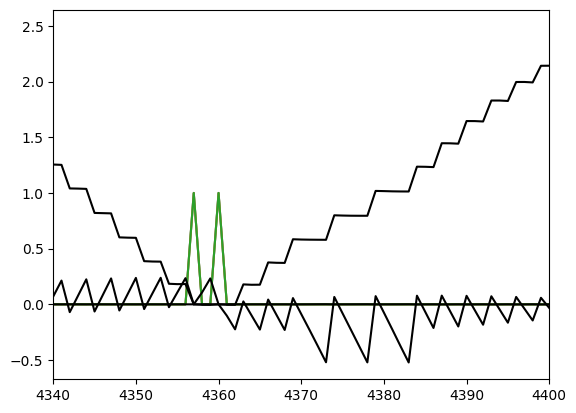

In [26]:
import matplotlib.pyplot as plt
forces = dataset[0]['nodes']['f_int'][10]*1e-2
forces_e = dataset[0]['nodes']['f_ext'][10]*5e-1
disp = dataset[0]['nodes']['u_ts'][10]*50
boundary = dataset[0]['nodes']['bc']
plt.plot(boundary)
#plt.plot(forces,'r')
#plt.plot(forces_e,'b')
plt.plot(disp,'k')
plt.xlim(4340,4400)

In [ ]:
import torch
dataset = torch.load("../torchfem_dataset/panel_plasticity_2/panel_combined.pt",weights_only=False)

: 

In [6]:
## Heterogeneous Graph Transformer - Dynamic over timesteps
from torch_geometric.data import DataLoader
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, to_hetero, HGTConv, Linear
from forward_src.hgt_conv import *
from forward_src.hgt_model import GNN, Matcher
import time
import torch
import numpy as np
import tqdm

#dataset = torch.load("../torchfem_dataset/panel_plasticity_2/panel_combined.pt",weights_only=False)
print(dataset[0].metadata())
device = 'cpu'
data = dataset[1]
#print(graph.keys)

data = T.AddSelfLoops()(data)
data = T.NormalizeFeatures()(data)

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

class HGT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers):
        super().__init__()

        self.lin_dict = torch.nn.ModuleDict()
        for node_type in data.node_types:
            self.lin_dict[node_type] = Linear(-1, hidden_channels)

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, data.metadata(),
                           num_heads)
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = {
            node_type: self.lin_dict[node_type](x).relu_()
            for node_type, x in x_dict.items()
        }

        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)

        return self.lin(x_dict['author'])

model = GNN(hidden_channels=64, out_channels=2)
model = to_hetero(model, data.metadata(), aggr='sum')
optimizer = torch.optim.AdamW(model.parameters())

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['paper'].train_mask
    loss = F.cross_entropy(out['paper'][mask], data['paper'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)



(['nodes', 'elements'], [('elements', 'contributes', 'nodes'), ('nodes', 'belongs_to', 'elements'), ('nodes', 'adjacent', 'nodes'), ('nodes', 'adjacent_rev', 'nodes')])


KeyError: "Tried to collect 'x' but did not find any occurrences of it in any node and/or edge type"

In [7]:
model.train()


GraphModule(
  (conv1): ModuleDict(
    (elements__contributes__nodes): SAGEConv((-1, -1), 64, aggr=mean)
    (nodes__belongs_to__elements): SAGEConv((-1, -1), 64, aggr=mean)
    (nodes__adjacent__nodes): SAGEConv((-1, -1), 64, aggr=mean)
    (nodes__adjacent_rev__nodes): SAGEConv((-1, -1), 64, aggr=mean)
  )
  (conv2): ModuleDict(
    (elements__contributes__nodes): SAGEConv((-1, -1), 2, aggr=mean)
    (nodes__belongs_to__elements): SAGEConv((-1, -1), 2, aggr=mean)
    (nodes__adjacent__nodes): SAGEConv((-1, -1), 2, aggr=mean)
    (nodes__adjacent_rev__nodes): SAGEConv((-1, -1), 2, aggr=mean)
  )
)

In [ ]:
## Training loop - direct import from HGT
from torch_geometric.data import DataLoader
from forward_src.hgt_conv import *
from forward_src.hgt_model import GNN, Matcher
import time
import torch
import numpy as np
import tqdm

dataset = torch.load("../torchfem_dataset/panel_plasticity_2/panel_combined.pt",weights_only=False)
print(dataset[0].metadata())
device = 'cpu'
graph = dataset[1]
#print(graph.keys)

types = graph.node_types

gnn = GNN(conv_name='hgt',in_dim=len(graph['nodes']),n_hid=64,n_heads=2,
          n_layers=3,dropout=0.1,num_types=len(types),num_relations=len(graph.edge_types)+1)
matcher = Matcher(64).to(device)
model = nn.Sequential(gnn,matcher)
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000, eta_min=1e-6)
loader = DataLoader(dataset)

def mask_softmax(pred, size):
    loss = 0
    stx = 0
    for l in size:
        loss += torch.log_softmax(pred[stx: stx + l], dim=-1)[0] / np.log(l)
        stx += l
    return -loss

stats = []
res = []
best_val   = 0
train_step = 1500

sample = next(iter(loader))
print(sample)



for epoch in range(50):
    model.train()
    train_losses = []
    #torch.cuda.empty_cache()

    for _ in range(2):
        for node_feature, node_type, edge_time, edge_index, edge_type, ylabel in train_data:
            node_rep = gnn.forward(node_feature.to(device), node_type.to(device),
                edge_time.to(device), edge_index.to(device), edge_type.to(device))
            author_key = []
            paper_key  = []
            key_size   = []
            for paper_id in ylabel:
                author_ids  = ylabel[paper_id]
                paper_key  += [np.repeat(paper_id, len(author_ids))]
                author_key += [author_ids]
                key_size   += [len(author_ids)]
            paper_key  = torch.LongTensor(np.concatenate(paper_key)).to(device)
            author_key = torch.LongTensor(np.concatenate(author_key)).to(device)

            train_paper_vecs  = node_rep[paper_key]
            train_author_vecs = node_rep[author_key]
            res = matcher.forward(train_author_vecs, train_paper_vecs, pair=True)
            loss = mask_softmax(res, key_size)


            optimizer.zero_grad() 
            torch.cuda.empty_cache()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
            optimizer.step()

            train_losses += [loss.cpu().detach().tolist()]
            train_step += 1
            scheduler.step(train_step)
            del res, loss
    model.eval()
    with torch.no_grad():
        node_feature, node_type, edge_time, edge_index, edge_type, ylabel = valid_data
        node_rep = gnn.forward(node_feature.to(device), node_type.to(device), \
                                   edge_time.to(device), edge_index.to(device), edge_type.to(device))

        author_key = []
        paper_key  = []
        key_size   = []
        for paper_id in ylabel:
            author_ids  = ylabel[paper_id]
            paper_key  += [np.repeat(paper_id, len(author_ids))]
            author_key += [author_ids]
            key_size   += [len(author_ids)]
        paper_key  = torch.LongTensor(np.concatenate(paper_key)).to(device)
        author_key = torch.LongTensor(np.concatenate(author_key)).to(device)
        
        valid_paper_vecs  = node_rep[paper_key]
        valid_author_vecs = node_rep[author_key]
        res = matcher.forward(valid_author_vecs, valid_paper_vecs, pair=True)
        loss = mask_softmax(res, key_size)
        '''
            Calculate Valid NDCG. Update the best model based on highest NDCG score.
        '''
        valid_res = []
        ser = 0
        for s in key_size:
            p = res[ser: ser + s]
            l = torch.zeros(s)
            l[0] = 1
            r = l[p.argsort(descending = True)]
            valid_res += [r.cpu().detach().tolist()]
            ser += s
        valid_ndcg = np.average([ndcg_at_k(resi, len(resi)) for resi in valid_res])
        valid_mrr  = np.average(mean_reciprocal_rank(valid_res))
        
        if valid_ndcg > best_val:
            best_val = valid_ndcg
            torch.save(model, os.path.join(args.model_dir, args.task_name + '_' + args.conv_name))
            print('UPDATE!!!')
        
        st = time.time()
        print(("Epoch: %d (%.1fs)  LR: %.5f Train Loss: %.2f  Valid Loss: %.2f  Valid NDCG: %.4f  Valid MRR: %.4f") % \
              (epoch, (st-et), optimizer.param_groups[0]['lr'], np.average(train_losses), \
                    loss.cpu().detach().tolist(), valid_ndcg, valid_mrr))
        stats += [[np.average(train_losses), loss.cpu().detach().tolist()]]
        del res, loss
    del train_data, valid_data


In [ ]:
## GraphNet Architecture

import torch
import torch.nn as nn

class GraphNetBlock(nn.Module):
    def __init__(self, node_dim, edge_dim, global_dim=0, hidden_dim=64):
        super().__init__()
        self.global_dim = global_dim

        # Edge update φ^e
        in_dim_e = edge_dim + 2*node_dim + global_dim
        self.edge_mlp = nn.Sequential(
            nn.Linear(in_dim_e, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, edge_dim)
        )

        # Node update φ^v
        in_dim_v = node_dim + edge_dim + global_dim
        self.node_mlp = nn.Sequential(
            nn.Linear(in_dim_v, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, node_dim)
        )

        self.global_mlp = None

    def forward(self, nodes, edges, senders, receivers, global_attr=None):
        N, E = nodes.size(0), edges.size(0)

        g_e = torch.zeros(E, 0, device=nodes.device)
        g_v = torch.zeros(N, 0, device=nodes.device)

        # ---- Edge update ----
        #print(edges.shape, nodes[senders].shape, nodes[receivers].shape, g_e.shape)
        edge_inputs = torch.cat([edges, nodes[senders], nodes[receivers], g_e], dim=-1)
        edges_updated = self.edge_mlp(edge_inputs)

        # ---- Node update ----
        agg_messages = torch.zeros(N, edges_updated.size(-1), device=nodes.device)
        agg_messages.index_add_(0, receivers, edges_updated)  # ρ^{e→v} = sum
        node_inputs = torch.cat([nodes, agg_messages, g_v], dim=-1)
        nodes_updated = self.node_mlp(node_inputs)

        return nodes_updated, edges_updated


In [2]:
## LSTM-Type Architecture with rollout

import torch
import torch.nn as nn

def reset_weights(m):
    if hasattr(m, "reset_parameters"):
        m.reset_parameters()

class GraphTemporalModel(nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim, out_dim):
        super().__init__()
        self.gn = GraphNetBlock(node_dim, edge_dim)
        self.rnn = nn.LSTM(input_size=node_dim, hidden_size=hidden_dim, batch_first=True)
        self.decoder = nn.Linear(hidden_dim, out_dim)
        self.reset_parameters()

    def reset_parameters(self):
        self.gn.apply(reset_weights)
        for name, param in self.rnn.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            else:
                nn.init.xavier_uniform_(param)
        nn.init.xavier_uniform_(self.decoder.weight)
        nn.init.zeros_(self.decoder.bias)


    def forward(self, x_t, edge_features, senders, receivers, h=None, c=None):
        """
        One-step prediction:
          x_t : [B, N, F]  current node features
          edge_features : [E, d_e]
          senders, receivers : [E]
          h, c : LSTM hidden + cell state
        Returns:
          x_next : [B, N, out_dim]
          (h, c) : updated hidden states
        """
        # Graph update
        gn_out, _ = self.gn(x_t, edge_features, senders, receivers)  # [B, N, F]

        # Reshape node features for RNN (flatten nodes as features)
        rnn_in = gn_out.reshape(gn_out.size(0), 1, -1)  # [B, 1, N*F]

        # RNN step
        if h is not None and c is not None:
            rnn_out, (h, c) = self.rnn(rnn_in, (h, c))
        else:
            rnn_out, (h, c) = self.rnn(rnn_in)

        # Decode next node features
        x_next = self.decoder(rnn_out)  # [B, 1, out_dim]
        x_next = x_next.squeeze(1)      # [B, out_dim]

        return x_next, (h, c)

    def rollout(self, node_init, edge_features, senders, receivers, steps): ##TODO: time-dependent
        """
        Autoregressive rollout for multiple steps.
          node_init : [B, N, F]  initial node features
          steps     : number of rollout steps
        Returns:
          preds : [B, steps, out_dim]
        """
        preds = []
        x_t = node_init
        h, c = None, None

        for _ in range(steps):
            x_t, (h, c) = self.forward(x_t, edge_features, senders, receivers, h, c)
            preds.append(x_t)

        return torch.stack(preds, dim=1)  # [B, steps, out_dim]



In [26]:
## LSTM-Type Architecture without rollout

def reset_weights(m):
    if hasattr(m, "reset_parameters"):
        m.reset_parameters()

class GraphTemporalModelNoRollout(nn.Module):
    def __init__(self, static_dim, state_dim, cond_dim, edge_dim, hidden_dim):
        super().__init__()
        self.static_dim = static_dim
        self.state_dim = state_dim
        self.cond_dim = cond_dim
        self.node_dim = static_dim + state_dim + cond_dim

        self.gn = GraphNetBlock(self.node_dim, edge_dim)
        self.rnn = nn.LSTM(input_size=self.node_dim, hidden_size=hidden_dim, batch_first=True)
        self.decoder = nn.Linear(hidden_dim, self.state_dim)
        self.reset_parameters()

    def reset_parameters(self):
        self.gn.apply(reset_weights)
        for name, param in self.rnn.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            else:
                nn.init.xavier_uniform_(param)
        nn.init.xavier_uniform_(self.decoder.weight)
        nn.init.zeros_(self.decoder.bias)

    def forward(self, state_t, cond_t, static_feat, edge_features, senders, receivers, hc=None):
        # combine current prediction with known context
        nodes = torch.cat([static_feat, state_t, cond_t], dim=-1)
        
        nodes, _ = self.gn(nodes, edge_features, senders, receivers)

        #rnn_in = nodes.reshape(1, 1, -1) if nodes.dim() == 2 else nodes.reshape(nodes.size(0), 1, -1)
        #print(self.state_dim,self.node_dim,nodes.shape)
        #print(nodes.shape,edge_features.shape,senders.shape,receivers.shape)
        rnn_out, hc = self.rnn(nodes, hc) if hc else self.rnn(nodes)
        #rnn_out, hc = self.rnn(rnn_in, hc) if hc else self.rnn(rnn_in)
        next_state = self.decoder(rnn_out.squeeze(1)).view_as(state_t)
        return next_state, hc

    def rollout(self, state_init, cond_seq, static_feat, edge_features, senders, receivers):
        preds = []
        state = state_init
        hc = None
        for cond_t in cond_seq:
            state, hc = self.forward(state, cond_t, static_feat, edge_features, senders, receivers, hc)
            preds.append(state)
        return torch.stack(preds, dim=0)


In [2]:
import torch
simdata = torch.load('../torchfem_dataset/panel_plasticity/simulation_dump_2.pt')

In [4]:
## Get Dataset

from torch.utils.data import Dataset, DataLoader
import torch

class GraphSeqDataset(Dataset):
    def __init__(self, pt_path):
        raw = torch.load(pt_path, map_location="cpu")
        # assume file is either a list[dict] or a dict of tensors
        if isinstance(raw, dict) and all(torch.is_tensor(v) for v in raw.values()):
            self.samples = [
                {k: v[i] for k, v in raw.items()}
                for i in range(next(iter(raw.values())).size(0))
            ]
        else:
            self.samples = raw

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        return {
            "node_features": sample["node_features"].float(),
            "edge_features": sample["edge_features"].float(),
            "senders": sample["senders"].long(),
            "receivers": sample["receivers"].long(),
            "target": sample.get("target", sample["node_features"]).float(),
        }

def graph_collate(batch):
    # handles batch size >1; adjust if sequences have different lengths
    out = {}
    for key in batch[0]:
        vals = [item[key] for item in batch]
        if key in {"senders", "receivers"}:
            out[key] = torch.stack(vals, dim=0)
        else:
            out[key] = torch.stack(vals, dim=0)
    return out

dataset = GraphSeqDataset("torchfem_dataset/panel_plasticity/panel_processed.pt")
loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=graph_collate)


In [ ]:
# GraphNet training loop - LSTM
from torch.utils.data import DataLoader
from torch import optim
import time

#dataset = torch.load('torchfem_dataset/panel_plasticity/simulation_.pt')
#loader = DataLoader(dataset, batch_size=1, shuffle=True)  # batch size 1 for rollout
device = 'cuda:0'
loader = DataLoader(dataset, batch_size=1, collate_fn=graph_collate)

sample = next(iter(dataset))
node_dim = sample["node_features"].shape[-1]
edge_dim = sample["edge_features"].shape[-1]
out_dim = node_dim                # or whatever target width you predict

gn = GraphTemporalModel(
    node_dim=node_dim,
    edge_dim=edge_dim,
    hidden_dim=128,
    out_dim=out_dim,
).to(device)
gn.apply(reset_weights)

optimizer = optim.AdamW(gn.parameters(), lr=5e-2)
loss_fn = nn.SmoothL1Loss() ##TODO: physics-informed loss
epochs = 10
losses = []

def rollout_from_dataset(gn, node_features_seq, edge_features, 
                         senders, receivers):
    """
    Unroll the GN across the sequence length T.
    """
    T, N, F = node_features_seq.shape[0], node_features_seq.shape[1], node_features_seq.shape[1:]
    preds = []

    nodes_t = node_features_seq[0]  # initial state
    for t in range(T-1):
        # forward pass
        #print(nodes_t.shape,edge_features.shape,senders.shape,receivers.shape)
        nodes_t, _= gn(nodes_t, edge_features, senders, receivers) #nodes_t,_,_
        preds.append(nodes_t)   # keep entire state prediction
    return torch.stack(preds, dim=0)  # [T-1, N, F]

max_batches = 5
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, batch in enumerate(loader):
        if batch_idx >= max_batches:
            break
        node_features_seq, edge_features, senders, receivers, target_seq = batch['node_features'],batch['edge_features'],batch['senders'],batch['receivers'],batch['node_features']
        
        node_features_seq = node_features_seq.squeeze(0)      # [T,N,F]
        steps = node_features_seq.shape[0]
        edge_features = edge_features.squeeze(0)              # [E,D]
        #global_features_seq = global_features_seq.squeeze(0)  # [T,G]
        target_seq = target_seq.squeeze(0)                    # [T,N,out_dim]
        senders = senders.squeeze(0)
        receivers = receivers.squeeze(0)
        #preds = rollout_from_dataset(gn, node_features_seq, edge_features,
        #    senders, receivers)

        preds = gn.rollout(node_features_seq[0], edge_features, senders, receivers, steps)
        preds = preds.permute(1,0,2)
        # preds covers [1..T-1], align with ground truth
        #print(preds.shape,target_seq.shape)
        loss = loss_fn(preds[1:], target_seq[1:])  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        #print(total_loss)
    losses.append(total_loss)

    #if epoch % 20 == 0:
    print(f"Epoch {epoch}, Loss={total_loss/len(loader):.2f}")
torch.save({'model':gn.state_dict(),'optimizer':optimizer.state_dict()},'torchfem_dataset/weights.pth')


torch.Size([32670, 9]) torch.Size([32670, 15]) torch.Size([32670, 15]) torch.Size([32670, 0])
torch.Size([32670, 9]) torch.Size([32670, 15]) torch.Size([32670, 15]) torch.Size([32670, 0])
torch.Size([32670, 9]) torch.Size([32670, 15]) torch.Size([32670, 15]) torch.Size([32670, 0])
torch.Size([32670, 9]) torch.Size([32670, 15]) torch.Size([32670, 15]) torch.Size([32670, 0])
torch.Size([32670, 9]) torch.Size([32670, 15]) torch.Size([32670, 15]) torch.Size([32670, 0])
torch.Size([32670, 9]) torch.Size([32670, 15]) torch.Size([32670, 15]) torch.Size([32670, 0])
torch.Size([32670, 9]) torch.Size([32670, 15]) torch.Size([32670, 15]) torch.Size([32670, 0])
torch.Size([32670, 9]) torch.Size([32670, 15]) torch.Size([32670, 15]) torch.Size([32670, 0])
torch.Size([32670, 9]) torch.Size([32670, 15]) torch.Size([32670, 15]) torch.Size([32670, 0])
torch.Size([32670, 9]) torch.Size([32670, 15]) torch.Size([32670, 15]) torch.Size([32670, 0])
torch.Size([32670, 9]) torch.Size([32670, 15]) torch.Size([3

KeyboardInterrupt: 

In [4]:
# GraphNet training loop - LSTM no rollout
from torch.utils.data import DataLoader
from torch import optim
import time

#dataset = torch.load('torchfem_dataset/panel_plasticity/simulation_.pt')
#loader = DataLoader(dataset, batch_size=1, shuffle=True)  # batch size 1 for rollout
device = 'cpu'
dataset = GraphSeqDataset("torchfem_dataset/panel_plasticity/panel_processed.pt")
loader = DataLoader(dataset, batch_size=1, collate_fn=graph_collate)

sample = next(iter(dataset))
node_features_seq, edge_features, senders, receivers, target_seq = sample['node_features'],sample['edge_features'],sample['senders'],sample['receivers'],sample['target']


node_features_seq = node_features_seq.squeeze(0)        # [T, N, F]
time_diff = node_features_seq[1:] - node_features_seq[:-1]
dynamic_mask = time_diff.abs().max(dim=0).values > 1e-6 # [N, F]
dynamic_mask = dynamic_mask.any(dim=0)                  # [F]
static_idx = (~dynamic_mask).nonzero(as_tuple=True)[0]
dynamic_idx = dynamic_mask.nonzero(as_tuple=True)[0]
static_feat = node_features_seq[0, :, static_idx]                     # [N, static_dim]
dynamic_seq = node_features_seq[:, :, dynamic_idx]                    # [T, N, dynamic_dim]
state_dim = dynamic_seq.size(-1) // 2
state_seq = dynamic_seq[:, :, :state_dim]
cond_seq = dynamic_seq[:, :, state_dim:]

gn = GraphTemporalModelNoRollout(
            static_dim=static_feat.size(-1),
            state_dim=state_dim,
            cond_dim=cond_seq.size(-1),
            edge_dim=edge_features.size(-1),
            hidden_dim=128,
        ).to(device)


optimizer = optim.AdamW(gn.parameters(), lr=1e-4)
loss_fn = nn.SmoothL1Loss() ##TODO: physics-informed loss
epochs = 50
losses = []



max_batches = 20
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, batch in enumerate(loader):
        if batch_idx >= max_batches:
            break
        node_features_seq, edge_features, senders, receivers, target_seq = batch['node_features'],batch['edge_features'],batch['senders'],batch['receivers'],batch['node_features']

        target_seq = target_seq.squeeze(0)                    # [T,N,out_dim]
        senders = senders.squeeze(0)
        receivers = receivers.squeeze(0)

        node_features_seq = node_features_seq.squeeze(0)        # [T, N, F]
        time_diff = node_features_seq[1:] - node_features_seq[:-1]
        dynamic_mask = time_diff.abs().max(dim=0).values > 1e-6 # [N, F]
        dynamic_mask = dynamic_mask.any(dim=0)                  # [F]
        static_idx = (~dynamic_mask).nonzero(as_tuple=True)[0]
        dynamic_idx = dynamic_mask.nonzero(as_tuple=True)[0]

        static_feat = node_features_seq[0, :, static_idx]                     # [N, static_dim]
        dynamic_seq = node_features_seq[:, :, dynamic_idx]                    # [T, N, dynamic_dim]
        state_dim = dynamic_seq.size(-1) // 2
        state_seq = dynamic_seq[:, :, :state_dim]
        cond_seq = dynamic_seq[:, :, state_dim:]

        state_init = state_seq[0]
        known_cond = cond_seq[:-1]          # length T-1 aligns with transitions
        target_states = state_seq[1:]       # ground truth next states
        
        #print(state_init.shape,known_cond.shape,static_feat.shape,edge_features[0].shape,senders.shape,receivers.shape)
        preds = gn.rollout(state_init, known_cond, static_feat, edge_features[0], senders, receivers)
        loss = loss_fn(preds, target_states)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        #print(total_loss)
    losses.append(total_loss)

    if epoch % 1 == 0:
        print(f"Epoch {epoch}, Loss={total_loss/len(loader):.4f}")
torch.save({'model':gn.state_dict(),'optimizer':optimizer.state_dict()},'torchfem_dataset/weights.pth')


Epoch 0, Loss=0.8523
Epoch 1, Loss=0.7015
Epoch 2, Loss=0.6442
Epoch 3, Loss=0.6116
Epoch 4, Loss=0.5959
Epoch 5, Loss=0.6105
Epoch 6, Loss=0.6002
Epoch 7, Loss=0.5837
Epoch 8, Loss=0.5658
Epoch 9, Loss=0.5793
Epoch 10, Loss=0.5763
Epoch 11, Loss=0.5647
Epoch 12, Loss=0.5635
Epoch 13, Loss=0.5601
Epoch 14, Loss=0.5546
Epoch 15, Loss=0.5596
Epoch 16, Loss=0.5559
Epoch 17, Loss=0.5433
Epoch 18, Loss=0.5412
Epoch 19, Loss=0.5465
Epoch 20, Loss=0.5280
Epoch 21, Loss=0.5311
Epoch 22, Loss=0.5313
Epoch 23, Loss=0.5687
Epoch 24, Loss=0.5426
Epoch 25, Loss=0.5404
Epoch 26, Loss=0.5236
Epoch 27, Loss=0.5113
Epoch 28, Loss=0.5009
Epoch 29, Loss=0.5004
Epoch 30, Loss=0.4960
Epoch 31, Loss=0.4959
Epoch 32, Loss=0.4878
Epoch 33, Loss=0.4831
Epoch 34, Loss=0.4783
Epoch 35, Loss=0.4780
Epoch 36, Loss=0.4779
Epoch 37, Loss=0.4723
Epoch 38, Loss=0.4774
Epoch 39, Loss=0.4753
Epoch 40, Loss=0.4814
Epoch 41, Loss=0.4810
Epoch 42, Loss=0.4757
Epoch 43, Loss=0.4698
Epoch 44, Loss=0.4631
Epoch 45, Loss=0.455

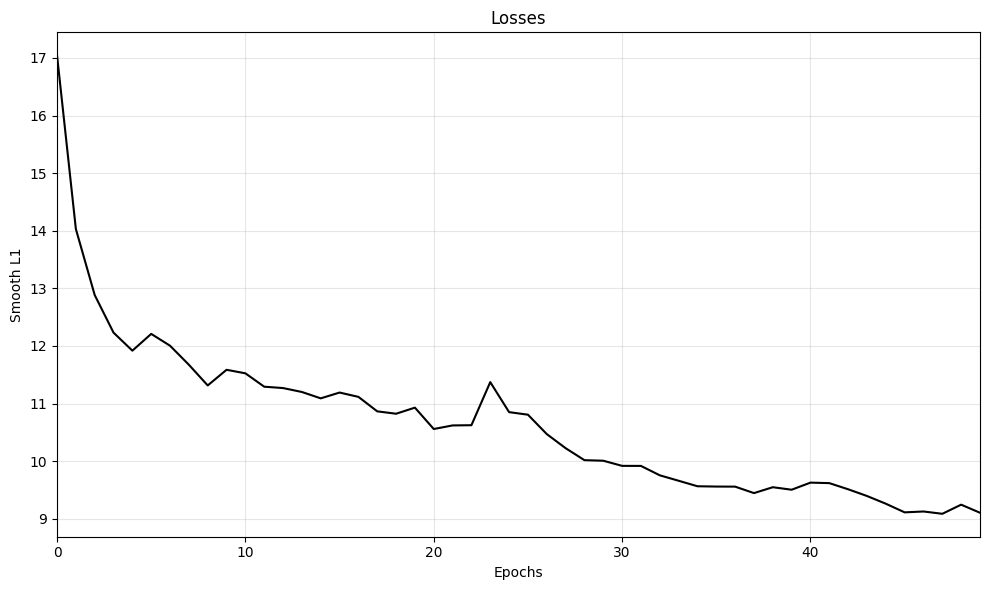

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.title('Losses')
plt.ylabel('Smooth L1')
plt.plot(losses,'k')
plt.xlabel('Epochs')
plt.xlim(0,len(losses)-1)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig('torchfem_dataset/losses.png',dpi=300)

In [ ]:
## DiffPool

import torch
import torch.nn as nn
from typing import Dict, Tuple


def build_dense_adj(senders: torch.Tensor, receivers: torch.Tensor, num_nodes: int) -> torch.Tensor:
    """
    Builds a symmetric adjacency matrix for a single graph.
    """
    adj = torch.zeros(num_nodes, num_nodes, device=senders.device)
    adj[senders, receivers] = 1.0
    adj[receivers, senders] = 1.0
    adj.fill_diagonal_(1.0)
    return adj


class GraphConv(nn.Module):
    """
    Lightweight message-passing block used both for embeddings and assignments.
    """

    def __init__(self, node_dim: int, edge_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.edge_mlp = nn.Sequential(
            nn.Linear(node_dim + edge_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.node_mlp = nn.Sequential(
            nn.Linear(node_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(
        self,
        nodes: torch.Tensor,
        edge_attr: torch.Tensor,
        senders: torch.Tensor,
        receivers: torch.Tensor,
    ) -> torch.Tensor:
        msg_input = torch.cat([nodes[senders], edge_attr], dim=-1)
        messages = self.edge_mlp(msg_input)

        agg = torch.zeros(nodes.size(0), messages.size(-1), device=nodes.device)
        agg.index_add_(0, receivers, messages)

        node_input = torch.cat([nodes, agg], dim=-1)
        return self.node_mlp(node_input)


class DiffPoolLayer(nn.Module):
    """
    Single DiffPool layer: learns cluster assignments and pooled embeddings.
    """

    def __init__(
        self,
        input_dim: int,
        edge_dim: int,
        hidden_dim: int,
        assign_dim: int,
        clusters: int,
    ):
        super().__init__()
        self.embed_gnn = GraphConv(input_dim, edge_dim, hidden_dim, hidden_dim)
        self.assign_gnn = GraphConv(input_dim, edge_dim, hidden_dim, clusters)
        self.assign_proj = nn.Linear(clusters, assign_dim)

    def forward(
        self,
        nodes: torch.Tensor,
        adj: torch.Tensor,
        edge_attr: torch.Tensor,
        senders: torch.Tensor,
        receivers: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor, Dict[str, torch.Tensor]]:
        z = self.embed_gnn(nodes, edge_attr, senders, receivers)
        s_logits = self.assign_gnn(nodes, edge_attr, senders, receivers)
        s = torch.softmax(s_logits, dim=-1)

        x_pooled = torch.matmul(s.transpose(0, 1), z)
        adj_pooled = torch.matmul(torch.matmul(s.transpose(0, 1), adj), s)

        info = {
            "assign_logits": s_logits,
            "assign_soft": s,
            "node_embed": z,
        }
        return x_pooled, adj_pooled, info


class GraphTemporalDiffPool(nn.Module):
    """
    Temporal forecaster with DiffPool for graph-level compression.
    """

    def __init__(
        self,
        node_dim: int,
        edge_dim: int,
        hidden_dim: int,
        out_dim: int,
        clusters: int,
    ):
        super().__init__()
        self.pre_gnn = GraphConv(node_dim, edge_dim, hidden_dim, hidden_dim)
        self.pool = DiffPoolLayer(hidden_dim, edge_dim, hidden_dim, hidden_dim, clusters)
        self.rnn = nn.LSTM(
            input_size=hidden_dim * clusters,
            hidden_size=hidden_dim,
            batch_first=True,
        )
        self.decoder = nn.Linear(hidden_dim, out_dim)

    def forward(
        self,
        x_t: torch.Tensor,
        edge_attr: torch.Tensor,
        senders: torch.Tensor,
        receivers: torch.Tensor,
        state: Tuple[torch.Tensor, torch.Tensor] | None = None,
    ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor], Dict[str, torch.Tensor]]:
        pooled_repr = []
        pool_info: Dict[str, torch.Tensor] = {}

        for b in range(x_t.size(0)):
            nodes = self.pre_gnn(x_t[b], edge_attr[b], senders[b], receivers[b])

            adj = build_dense_adj(senders[b], receivers[b], nodes.size(0))
            x_pool, _, info = self.pool(
                nodes,
                adj,
                edge_attr[b],
                senders[b],
                receivers[b],
            )

            pooled_repr.append(x_pool.reshape(-1))
            if b == 0:
                pool_info = {k: v.detach() for k, v in info.items()}

        rnn_in = torch.stack(pooled_repr, dim=0).unsqueeze(1)

        if state is None:
            rnn_out, state = self.rnn(rnn_in)
        else:
            rnn_out, state = self.rnn(rnn_in, state)

        preds = self.decoder(rnn_out.squeeze(1))
        return preds, state, pool_info

    def rollout(
        self,
        node_init: torch.Tensor,
        edge_attr: torch.Tensor,
        senders: torch.Tensor,
        receivers: torch.Tensor,
        steps: int,
    ) -> torch.Tensor:
        preds = []
        x_t = node_init
        state = None

        for _ in range(steps):
            x_t, state, _ = self.forward(x_t, edge_attr, senders, receivers, state)
            preds.append(x_t)

        return torch.stack(preds, dim=1)


if __name__ == "__main__":
    torch.manual_seed(0)

    batch_size, num_nodes, node_dim = 1, 6, 4
    edge_dim, clusters = 3, 3
    out_dim, rollout_steps = node_dim, 5

    node_features = torch.randn(batch_size, num_nodes, node_dim)

    edge_list = []
    for i in range(num_nodes):
        j = (i + 1) % num_nodes
        edge_list.append((i, j))
        edge_list.append((j, i))

    senders = torch.tensor([s for s, _ in edge_list]).unsqueeze(0)
    receivers = torch.tensor([r for _, r in edge_list]).unsqueeze(0)
    edge_features = torch.randn(batch_size, len(edge_list), edge_dim)

    model = GraphTemporalDiffPool(
        node_dim=node_dim,
        edge_dim=edge_dim,
        hidden_dim=32,
        out_dim=out_dim,
        clusters=clusters,
    )

    out, _, info = model(node_features, edge_features, senders, receivers)
    print("Single step output:", out.shape)
    print("Assignment matrix example:", info["assign_soft"].shape)

    preds = model.rollout(
        node_features,
        edge_features,
        senders,
        receivers,
        steps=rollout_steps,
    )
    print("Rollout output:", preds.shape)

    # Expand: swap synthetic data with the real FEM dataset loader, add batching >1,
    #         and plug the pooled embeddings into your training loop with losses/metrics.
